In [20]:
import numpy as np
import pandas as pd
import os, sys
import shutil
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
from sklearn.utils import class_weight, shuffle
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from sklearn.model_selection import train_test_split
import warnings
import shutil
warnings.filterwarnings("ignore")

WORKERS = 2
CHANNEL = 3
IMG_SIZE = 224
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train
root_path = './data/pre'
path_from = './data/pre/raw/'
test_path_to = './data/pre/test_images/'
train_path_to = './data/pre/train_images/'
TRAIN_DF = pd.read_csv('./data/train.csv')

'''0': [1443, 362],
 '1': [295, 75],
 '2': [799, 200],
 '3': [154, 39],
 '4': [235, 60]}'''

"0': [1443, 362],\n '1': [295, 75],\n '2': [799, 200],\n '3': [154, 39],\n '4': [235, 60]}"

In [68]:

    

        
def split_train_test(df,t = 0.1):
    for i in range(100):
        df = df.sample(frac = 1).reset_index(drop=True)
    lengths = dict()
    for i in range(5):
        subdf = df[df['diagnosis'] == i].copy().reset_index(drop = True)
        trainsz = subdf.shape[0]
        testsz = 1 + int(t * trainsz)
        trainsz -= testsz
        trainv = [os.path.join(path_from,x + '.png') for x in subdf.loc[:trainsz-1 ,'id_code']]
        testv = [os.path.join(path_from,x + '.png') for x in subdf.loc[trainsz:,'id_code']]
        target_train = os.path.join(train_path_to,str(i))
        target_test = os.path.join(test_path_to,str(i))
        if not os.path.exists(target_train):
            os.makedirs(target_train)
        if not os.path.exists(target_test):
            os.makedirs(target_test)
        for file_name in trainv:
            shutil.copy(file_name,target_train)
        for file_name in testv:
            shutil.copy(file_name,target_test)
        lengths[str(i)] = [len(trainv), len(testv)]
    return lengths
            
def spoil_image(img):
    sigma = np.random.choice(20,1)[0]
    noise = np.random.normal(0,sigma,img.shape)
    img=cv2.addWeighted(img.astype(float),1, noise ,1 ,0)
    lx = img < 0
    img[lx] = 0
    lx = img > 255
    img[lx] = 255
    return img

def augment(maxCnt):
    gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 10, preprocessing_function = spoil_image)
    for i in range(5):
        targetdir = os.path.join(train_path_to,str(i))
        augdir = os.path.join(targetdir,'augment')
        realimgdir = os.path.join(targetdir,str(i))
        cnt = len([f for f in os.listdir(realimgdir) if os.path.isfile(os.path.join(realimgdir,f))])
        if cnt < maxCnt:
            batch_sz = cnt
            epochs =1 + ((maxCnt - cnt) // batch_sz)
            for j in range(epochs):
                tr_gen = gen.flow_from_directory(target_size = (IMG_SIZE, IMG_SIZE), 
                                                 directory = targetdir,
                                                 save_to_dir = targetdir,
                                                 save_prefix = 'pr_' + str(i)+ '_' + str(j),
                                                 batch_size = batch_sz) 
                iter(tr_gen).next()
                
def make_new_train_table(maxCnt):
    dictpd = {'filename' : [], 'class' : [], 'type' : []}
    types = []
    for i in range(5):
        targetdir = os.path.join(train_path_to,str(i))
        subdir = os.path.join(targetdir,str(i))
        filenames = ['./{}/{}/{}'.format(i,i,f) for f in os.listdir(subdir) if os.path.isfile(os.path.join(subdir,f))]
        types = [0] * len(filenames)
        augFilenames = ['./{}/{}'.format(i,f) for f in os.listdir(targetdir) if os.path.isfile(os.path.join(targetdir,f))]
        augFilenames.sort()
        extendLen = maxCnt - len(filenames)
        if extendLen > 0:
            filenames += augFilenames[0 : extendLen]
            types += [int(s.split('_')[2]) + 1 for s in augFilenames[0 : extendLen]]
        dictpd['filename'] += filenames
        dictpd['class'] += [i]*maxCnt
        dictpd['type'] += types
    return pd.DataFrame(dictpd)

def make_new_test_table():
    dictpd = {'filename' : [], 'class' : [],'type' : []}
    for i in range(5):
        targetdir = os.path.join(test_path_to,str(i))
        filenames = ['./{}/{}'.format(i,f) for f in os.listdir(targetdir) if os.path.isfile(os.path.join(targetdir,f))]
        cnt = len(filenames)
        dictpd['filename'] += filenames
        dictpd['class'] += [i]*cnt
        dictpd['type'] += [0]*cnt
    return pd.DataFrame(dictpd)

In [ ]:
augment(1443)

In [71]:
train_df = make_new_train_table(1443)
test_df = make_new_test_table()
train_df.to_csv(os.path.join(root_path,'train.csv'),index = False)
test_df.to_csv(os.path.join(root_path,'test.csv'),index = False)

In [ ]:
path = r'C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\aptos_2019\data\raw\train_images\0b3efe669365.png'
timg = ImagePreprocessing()
img1 = timg(path)
img2 = timg(path)
#plt.imshow(img.numpy())
img = img1 + img2

In [22]:
df = pd.read_csv(r'C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\APTOS\references\raw_train.csv')

In [12]:
import os
p1 = r'C:\Users\PLDD\Practice\GitHub'
p2 = r'./Python/ML/Kaggle/APTOS'
p3 = r'\references\raw_train.csv'
os.path.exists(os.path.join(p1,p2))

True

In [26]:
path1 = r'C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\APTOS\references\raw_train.csv'
path2 = r'C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\APTOS1\references1\raw_trai1n.csv'
os.path.commonpath([path1, path2])

'C:\\Users\\PLDD\\Practice\\GitHub\\Python\\ML\\Kaggle'

In [16]:
os.path.split(path)

('C:\\Users\\PLDD\\Practice\\GitHub\\Python\\ML\\Kaggle\\APTOS\\references',
 'raw_train.csv')

In [21]:
file = r'C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\APTOS\references\aug_2_1.png'
_, file = os.path.split(file)
file = os.path.splitext(file)[0]
int(file.split('_')[2])

1

In [39]:
os.path.exists('C:\\Users\\PLDD\\Practice\\GitHub\\Python\\ML\\Kaggle\\APTOS\\references')

True

In [18]:
os.path.splitext(path)

('C:\\Users\\PLDD\\Practice\\GitHub\\Python\\ML\\Kaggle\\APTOS\\references\\raw_train',
 '.csv')

In [33]:
class A:
    def __init__(self):
        return
v = A()

In [110]:
class Transformation(object):
    def __init__(self):
        pass
    def __call__(self,image):
        return image

class Resize(Transformation):
    '''
        method - one of the tf.image.ResizeMethod
    '''
    def __init__(self, size = None, method = tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio = False, antialias = False):
        super().__init__()
        self.method = method
        self.preserve_aspect_ratio = preserve_aspect_ratio
        self.antialias = antialias
        self.size = size
    def __call__(self,image = None):
        if self.size is None or image is None:
            return super().__call__(image)
        return tf.image.resize(image, self.size, method=self.method, 
                               preserve_aspect_ratio=self.preserve_aspect_ratio, 
                               antialias=self.antialias, name=None).numpy()
class Cropp(Transformation):
    def __init__(self, tolerance = None):
        super().__init__()
        self.tolerance = tolerance
    def __call__(self,image = None):
        if image is None or self.tolerance is None:
            return super().__call__(image)
        return self.__cropImage__(image)
    def __cropImage__(self, image):
        grayImage = tf.image.rgb_to_grayscale(image)
        mask = tf.greater(grayImage, self.tolerance)
        rows = tf.reshape(tf.reduce_any(mask,1), (-1,1))
        r_sz = tf.reduce_sum(tf.cast(rows,tf.int32));
        cols = tf.reshape(tf.reduce_any(mask,0),(1,-1))
        c_sz = tf.reduce_sum(tf.cast(cols,tf.int32))
        if c_sz == 0 or r_sz == 0:
            return image
        mask = tf.logical_and(rows,cols)
        newImage = []
        for i in range(3):
            newImage.append(tf.reshape(tf.boolean_mask(image[:,:,i],mask),(r_sz,c_sz)))
        return tf.stack(newImage,axis = 2).numpy()
    
class Sharppen(Transformation):
    def __init__(self, sigma = None):
        super().__init__()
        self.sigma = sigma
    def __call__(self, image = None):
        if image is None or self.sigma is None:
            return super().__call__(image)
        img = cv2.addWeighted ( image,4, cv2.GaussianBlur( image, (0,0) , self.sigma) ,-4 ,128)
        #img = np.clip(img,0,255)
        return img
    
class CircleMask(Transformation):
    def __init__(self):
        super().__init__()
    def __call__(self,image):
        if image is None:
            return super().__call__(image)
        height, width, depth = image.shape    
        x = int(width/2)
        y = int(height/2)
        r = np.amin((x,y))
        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        return cv2.bitwise_and(image, image, mask=circle_img)

class AddGauseNoise(Transformation):
    def __init__(self,supperSigma = 1):
        super().__init__()
        self.SupperSigma = supperSigma
        
    def __call__(self, image):
        if image is None:
            return super().__call__(image)
        sigmav = np.random.choice(self.SupperSigma, 3)
        noise = np.random.normal(0,sigmav,image.shape)
        return np.clip(noise + image,0.,255.)

class RandomVisualEffect(Transformation):
    def __init__(self):
        super().__init__()
        self.rot = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE,cv2.ROTATE_180]
    
    def __call__(self, image):
        if image is None:
            return super().__call__(image)
        rix = np.random.choice(3,1)[0]
        image = cv2.rotate(image,self.rot[rix])
        image = tf.image.adjust_contrast(image, 1.0 + 2.0 * np.random.random())
        image = tf.image.random_hue(image,0.5)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        return image.numpy() #np.clip(image.numpy(),0., 255.)
    
class Pipe(Transformation):
    def __init__(self,trans = None):
        super().__init__()
        self.trans = trans
    def __call__(self,image):
        if self.trans is None or image is None:
            return super().__call__(image)
        for tr in self.trans:
            image = tr(image)
        return image
    

class ImagePreprocessing(object):
    def __init__(self, transforms = Transformation()):
        self.transforms = transforms
        self.oimg = None
        self.timg = None
        
    def __call__(self,image):
        self.oimg = image
        self.timg = self.transforms(self.oimg)
        if self.timg is not None:
            self.timg = self.timg.astype('uint8')
        return self.timg
    
    def CompareImages(self):
        fig = plt.figure(figsize=(16,16))
        fig.add_subplot(1,2,1)
        plt.imshow(self.oimg)
        fig.add_subplot(1,2,2)
        plt.imshow(self.timg)

    def SaveModifiedImage(self, path):
        cv2.imwrite(path,self.timg)

    def LoadImage(path):
        if os.path.isfile(path):
            return cv2.imread(path)
        return None

def PreprocessImage(cropTol = 7, sigma = 120):
    cm = CircleMask()
    crop = Cropp(cropTol)
    resize = Resize((224,224))
    sharp = Sharppen(sigma)
    return ImagePreprocessing(Pipe([cm, crop, resize, sharp]))

def Augmentation(sigma = 1):
    visEffects = RandomVisualEffect()
    gaussNoise = AddGauseNoise(sigma)
    return ImagePreprocessing(Pipe([visEffects,gaussNoise]))

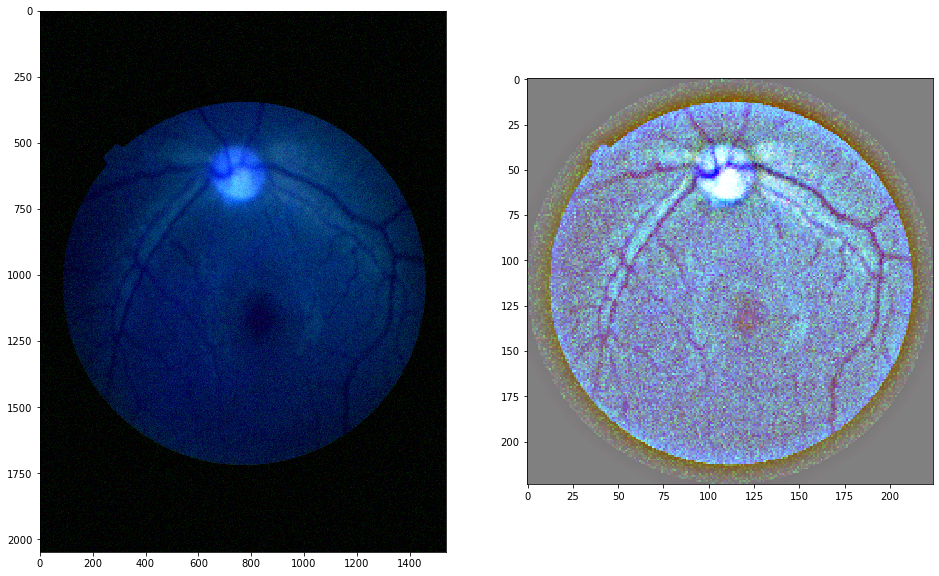

In [111]:
def PreprocessImage(cropTol = 7, sigma = 64):
    cm = CircleMask()
    crop = Cropp(cropTol)
    resize = Resize((224,224))
    sharp = Sharppen(sigma)
    return ImagePreprocessing(Pipe([cm, crop,sharp,resize]))

path = r'C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\aptos_2019\data\raw\train_images\0b3efe669365.png'
imgPrep = PreprocessImage(cropTol = 7, sigma = 42)
imgAugm = Augmentation(sigma = 16)

img = ImagePreprocessing.LoadImage(path)
img = imgAugm(img)
#img = img / np.max(img)
#for i in range(3):
#    img[:,:,i] = img[:,:,i] / np.max(img[:,:,i])
#plt.imshow(img)
img = imgPrep(img)
imgPrep.CompareImages()

In [89]:
np.max(img)

255

In [116]:
v = ['a', 'b']*4

In [117]:
v

['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b']

In [118]:
v[:7]

['a', 'b', 'a', 'b', 'a', 'b', 'a']

In [ ]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    #image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    #img = cv2.resize(img,(224,224))
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [ ]:
if os.path.exists(path_to) == False:
    os.mkdir(path_to)

cnt = 0
for idd in x.values:
    if cnt > 0:
        break
    cnt += 1
    path = path_from + idd + '.png'
    for ii in [1,2,3,4,5,6,8,9,10]:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_image_from_gray(image)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,ii, cv2.GaussianBlur( image , (0,0) , 30) ,-ii ,128)
        print("min = {}; max = {}.".format(np.min(image),np.max(image)))
        path1 = './data/' + idd + '_{}'.format(ii) + '.png'
        cv2.imwrite(path1,image)

In [ ]:
image

In [ ]:
if os.path.exists(path_to) == False:
    os.mkdir(path_to)

for sx in range(110,510,10):
    path_to_to = path_to + '{}/'.format(sx)
    if os.path.exists(path_to_to):
        shutil.rmtree(path_to_to)
    os.mkdir(path_to_to)
    cnt0 = 0
    cnt2 = 0
    for idd, diagnos in zip(x.values,y.values):
        flag = False
        if diagnos == 0 and cnt0 < 10:
            cnt0 +=1
            flag = True    
        if diagnos == 2 and cnt2 < 10:
            cnt2 +=1
            flag = True
        if flag == False:
            continue
        path = path_from + idd + '.png'
        #print(path)
        #img = circle_crop(path,sigmaX=30)
        img = load_ben_color(path, sx)
        path = path_to_to + idd + '_{}'.format(diagnos) + '.png'
        print(path)
        cv2.imwrite(path,img)
   

In [ ]:
x[1000]

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In [ ]:
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image=cv2.addWeighted ( image, 0 , cv2.GaussianBlur( image , (0 ,0 ) , 10) ,-4 ,128)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In [ ]:
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

In [ ]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [ ]:
%%time
## try circle crop
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = circle_crop(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

In [ ]:
%%time
NUM_SAMP=10
fig = plt.figure(figsize=(25, 16))
for jj in range(5):
    for i, (idx, row) in enumerate(df_test.sample(NUM_SAMP,random_state=SEED+jj).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, jj * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"./data/raw/test_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)
        
        plt.imshow(image)
        ax.set_title('%d-%s' % (idx, row['id_code']) )

In [ ]:
image = load_ben_color(path,sigmaX=30)
plt.imshow(image)

In [ ]:
cv2.imwrite('./xxx.png',image)